In [121]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [122]:
data_train = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/train.csv')

data_test = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/test.csv')

In [123]:
data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,51.00,0,1,458654,30.92,NaN,S


In [124]:
print('Missing values in train dataset')
print(data_train.isnull().sum())

Missing values in train dataset
PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64


In [125]:
print('Unique values in train dataset')
print(data_train.nunique())

Unique values in train dataset
PassengerId    100000
Survived            2
Pclass              3
Name            92144
Sex                 2
Age               173
SibSp               7
Parch               8
Ticket          75331
Fare            15935
Cabin           26992
Embarked            3
dtype: int64


In [126]:
print('Missing values in test dataset')
print(data_test.isnull().sum())

Missing values in test dataset
PassengerId        0
Pclass             0
Name               0
Sex                0
Age             3487
SibSp              0
Parch              0
Ticket          5181
Fare             133
Cabin          70831
Embarked         277
dtype: int64


In [127]:
print('Missing values in test dataset')
print(data_test.nunique())

Missing values in test dataset
PassengerId    100000
Pclass              3
Name            90808
Sex                 2
Age               159
SibSp               7
Parch               8
Ticket          75432
Fare            16554
Cabin           25216
Embarked            3
dtype: int64


In [128]:
def label_encoder(column):
    lc = LabelEncoder()
    return lc.fit_transform(column)

In [129]:
def titanic_preprocessing(df):
    age = df[['Age', 'Pclass']].dropna().groupby('Pclass').mean().to_dict()
    df['Age'] = df['Age'].fillna(df['Pclass'].map(age['Age']))

    df['Fare'].fillna(df['Fare'].median(), inplace=True)

    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

    # Ticked
    df['Ticket'] = df['Ticket'].fillna('X').map(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else 'X')

    # Cabin
    df['Cabin'] = df['Cabin'].fillna('X').map(lambda x: x[0].strip()) 

    df.drop(['PassengerId', 'Name'], axis=1, inplace=True)

    return df

In [130]:
def titanic_feature_engineering(df):
    # Create dummy variables
    dummy = pd.get_dummies(df[['Embarked', 'Cabin']], dtype=np.int32)
    df = pd.concat([df, dummy], axis=1)
    df.drop(['Embarked', 'Cabin'], axis=1, inplace=True)

    # Label Encoder
    ticket_labeled = df[['Ticket']].apply(label_encoder)
    ticket_labeled.columns = ['Ticket labeled']
    df = pd.concat([df, ticket_labeled], axis=1)
    df.drop(['Ticket'], axis=1, inplace=True)

    df['Sex_dummy'] = df['Sex'].map({'male': 0, 'female': 1})
    df.drop(['Sex'], axis=1, inplace=True)

    return df

In [131]:
def dataset_preparation(df):
    df = titanic_preprocessing(df)
    df = titanic_feature_engineering(df)
    return df

In [132]:
data_train_copy = data_train.copy()
data_test_copy = data_test.copy()

data_train_prep = dataset_preparation(data_train_copy)
data_test_prep = dataset_preparation(data_test_copy)

In [133]:
data_train_prep

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Ticket labeled,Sex_dummy
0,1,1,44.774464,2,0,27.14,0,0,1,0,0,1,0,0,0,0,0,0,49,0
1,0,3,33.407362,0,0,13.35,0,0,1,0,0,0,0,0,0,0,0,1,49,0
2,0,3,0.330000,1,2,71.29,0,0,1,0,0,0,0,0,0,0,0,1,14,0
3,0,3,19.000000,0,0,13.04,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,1,3,25.000000,0,0,7.76,0,0,1,0,0,0,0,0,0,0,0,1,49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,62.000000,0,0,14.86,1,0,0,0,0,0,1,0,0,0,0,0,21,1
99996,0,2,66.000000,0,0,11.15,0,0,1,0,0,0,0,0,0,0,0,1,49,0
99997,0,3,37.000000,0,0,9.95,0,0,1,0,0,0,0,0,0,0,0,1,49,0
99998,0,3,51.000000,0,1,30.92,0,0,1,0,0,0,0,0,0,0,0,1,49,0


In [134]:
data_train_prep

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Ticket labeled,Sex_dummy
0,1,1,44.774464,2,0,27.14,0,0,1,0,0,1,0,0,0,0,0,0,49,0
1,0,3,33.407362,0,0,13.35,0,0,1,0,0,0,0,0,0,0,0,1,49,0
2,0,3,0.330000,1,2,71.29,0,0,1,0,0,0,0,0,0,0,0,1,14,0
3,0,3,19.000000,0,0,13.04,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,1,3,25.000000,0,0,7.76,0,0,1,0,0,0,0,0,0,0,0,1,49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,62.000000,0,0,14.86,1,0,0,0,0,0,1,0,0,0,0,0,21,1
99996,0,2,66.000000,0,0,11.15,0,0,1,0,0,0,0,0,0,0,0,1,49,0
99997,0,3,37.000000,0,0,9.95,0,0,1,0,0,0,0,0,0,0,0,1,49,0
99998,0,3,51.000000,0,1,30.92,0,0,1,0,0,0,0,0,0,0,0,1,49,0


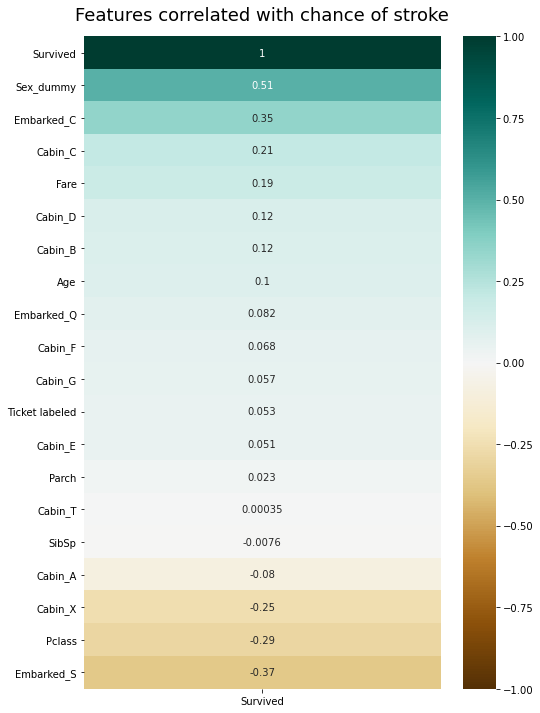

In [135]:
plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(data_train_prep.corr()[['Survived']].sort_values(by='Survived', ascending=False),
                     vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Features correlated with chance of stroke', fontdict={'fontsize': 18}, pad=16);

In [136]:
# Split data into train and validation sets
X = data_train_prep.drop(['Survived'], axis=1)
y = data_train_prep['Survived']

# Scalling
# scaler = StandardScaler()
# X[X.columns] = scaler.fit_transform(X[X.columns])
# data_test_scaled = scaler.fit_transform(data_test_prep)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [137]:
def model_evaluation(model):
    # Train our model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # F1 score
    scores_f1 = cross_val_score(model, X, y, scoring = 'f1' ,cv=5)
    print('F1 scores: {}'.format(scores_f1))
    print('F1 mean score: {}'.format(scores_f1.mean()))

    # Accuracy score
    scores_acc = cross_val_score(model, X, y, cv=5)
    print('Acc scores: {}'.format(scores_acc))
    print('Acc mean score: {}'.format(scores_acc.mean()))
    
    # Confusion matrix
    print('Confusion Matrix: ')
    matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts =['{0:0.0f}'.format(value) for value in matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(matrix, annot=labels, fmt='', cmap='rocket_r')

In [138]:
# get a list of models to evaluate
def get_models():
	models = dict()
	trees = range(50, 150, 5)
	for n in trees:
		models[str(n)] = LGBMClassifier(n_estimators=n)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
	return scores

In [139]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>50 0.746 (0.005)
>55 0.746 (0.005)


In [116]:
fig = go.Figure()

for num, result in enumerate(results):
    fig.add_trace(go.Box(
    y = result,
    name=names[num]
    ))

fig.show()

F1 scores: [0.74389604 0.74432321 0.7492598  0.74661081 0.74653893]
F1 mean score: 0.7461257584998738
Acc scores: [0.78025 0.78325 0.78405 0.78225 0.78305]
Acc mean score: 0.78257
Confusion Matrix: 


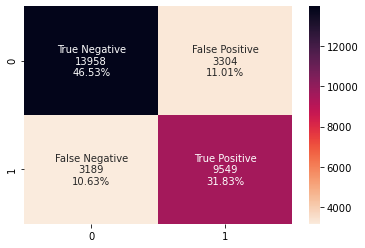

In [117]:
# LightGBM
LGBM_model = LGBMClassifier(n_estimators=55)
model_evaluation(LGBM_model)

In [118]:
# parameters = {
#     'num_leaves': range(25, 50, 1)
# }

# search = GridSearchCV(LGBM_model, parameters, verbose=3, scoring='f1')
# search.fit(X_train, y_train)

In [119]:
# print('Best Score for LGB: {} \nWith params: {}'.format(search.best_score_, search.best_params_))

In [120]:
# LGBM_model = LGBMClassifier()
LGBM_model.fit(X, y)
y_pred = LGBM_model.predict(data_test_prep)

my_submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': y_pred})
my_submission.to_csv('submission_v4.csv', index=False)